
### Imports

In [89]:
%pylab inline
import healpy
from scipy.interpolate import InterpolatedUnivariateSpline

Populating the interactive namespace from numpy and matplotlib


/home/ophilcox/.conda/envs/sbi/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Options

In [206]:
Nside = 128
lmax = 3*Nside-1
print("lmax: %d"%lmax)

# Binning parameters
dl = 16 # width
Nl = 20 # number
min_l = 2 # minimum
print("binned lmax: %d"%(min_l+dl*Nl))

# Number of random iterations
N_it = 20

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

lmax: 383
binned lmax: 322


### Fiducial Power and Noise Spectrum

In [207]:
from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)
l_arr,m_arr = healpy.Alm.getlm(lmax)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))

# Interpolate to all ell, m grid
Cl_th_interp = InterpolatedUnivariateSpline(l,Cl_th)
Nl_th_interp = InterpolatedUnivariateSpline(l,Nl_th)
Cl_th_lm = Cl_th_interp(l_arr)
Nl_th_lm = Nl_th_interp(l_arr)

# Zero out ell = 0 and ell = 1
Cl_th_lm[l_arr<2] = 0.
Nl_th_lm[l_arr<2] = 0.

### Load mask

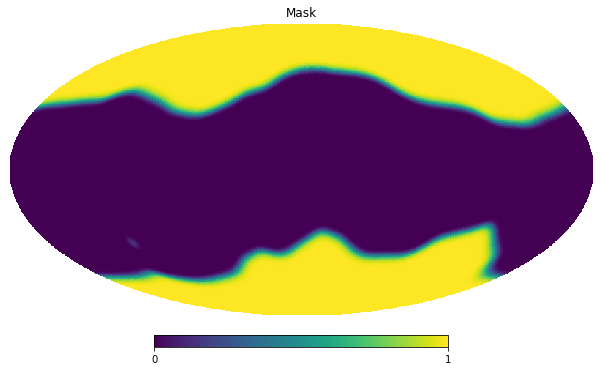

In [208]:
mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
healpy.mollview(mask,title='Mask')

### Generate Synthetic Data

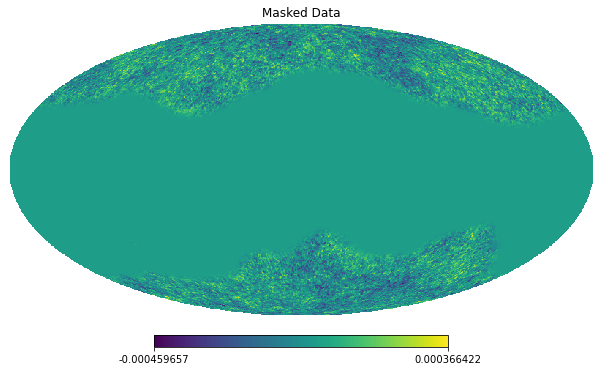

In [209]:
# Generate unmasked data
raw_data = healpy.synfast(Cl_th+Nl_th,Nside)

# Mask the map
data = raw_data*mask

# Plot the data
healpy.mollview(data,title='Masked Data')

# Key Functions

### Creation of $A^{-1}$ weights 

**Ignoring pixel weights**, relation between discrete real- and harmonic-space is
$$a_{\ell m} = \frac{4\pi}{N}\sum_{p}Y_{\ell m}^*(\hat n_p)a(\hat n_p) \quad\leftrightarrow\quad a(\hat n_p) = \sum_{\ell m}Y_{\ell m}(\hat n_p)a_{\ell m}$$
for $N$ pixels.

Thus, the multiplication of two maps is given by
$$\frac{4\pi}{N}\sum_{p}a(\hat n_p)b(\hat n_p) = \sum_{\ell,m\geq 0}a_{\ell m}b^*_{\ell m}\left[1+\delta^{\rm K}_{m>0}\right]$$

We want to create a function $A^{-1}$ that satisfies $\int d\hat n'A^{-1}(\hat n,\hat n')\langle{a(\hat n')a(\hat n'')\rangle} = \delta_{\rm D}(\hat n-\hat n'')$ in continuous space, or, in discrete map-space: $\left(\frac{4\pi}{N}\right)^2\sum_{jk}A^{-1}(\hat n_i,\hat n_j)\langle a(\hat n_j)a(\hat n_k)\rangle \beta(\hat n_k) = \beta(\hat n_i)$ for arbitrary $\beta$. This implies:
\begin{eqnarray}
    A^{-1}(\hat n_i,\hat n_j) =\sum_{\ell m}\frac{1}{C^a_{\ell}}Y_{\ell m}(\hat n_i)Y^*_{\ell m}(\hat n_j)
\end{eqnarray}
A good way to test this is by computing
$$\left(\frac{4\pi}{N}\right)^2\sum_{ij}\alpha(\hat n_i)A^{-1}(\hat n_i,\hat n_j)$$
which should equal $(\ell_{\rm max}+1)^2$.

In [210]:
# Basic HEALPix utilities
def to_lm(input_map):
    """Convert from map-space to harmonic-space"""
    return healpy.map2alm(input_map,pol=False)
def to_map(input_lm):
    """Convert from harmonic-space to map-space"""
    return healpy.alm2map(input_lm,Nside,pol=False)

def safe_divide(x,y):
    """Function to divide maps without zero errors."""
    out = np.zeros_like(x)
    out[y!=0] = x[y!=0]/y[y!=0]
    return out
    
av_sq_mask = np.mean(mask**2)
A_pix = 4.*np.pi/len(mask)
    
def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular (C_l + N_l) and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = to_map(safe_divide(input_map_lm,Cl_th_lm+Nl_th_lm))
    
    return Cinv_map

def generate_alpha(seed):
    """Generate a Gaussian random field with a known (exact) power spectrum.
    
    Here, we assume that the power spectrum is diagonal in ell without a window."""
    # Set seed
    np.random.seed(seed)
    # Generate spectrum
    return healpy.synfast(Cl_th+Nl_th,Nside)

def applyAinv(input_map):
    """Apply the exact inverse weighting A^{-1} to a map."""
    
    # Transform to harmonic space
    input_map_lm = to_lm(input_map)
    # Divide by covariance and return to map-space
    output = to_map(safe_divide(input_map_lm,Cl_th_lm+Nl_th_lm))
    return output

### Compute True Power Spectra

(2.0, 383.0)

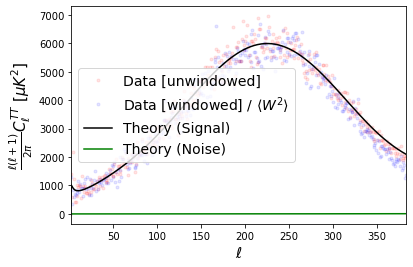

In [214]:
# Compute power spectra
Cl_raw_data = healpy.alm2cl(to_lm(raw_data))
Cl_data = healpy.alm2cl(to_lm(data))/av_sq_mask

# Plot results
pref = l*(l+1)/(2.*np.pi)*1e12
plt.plot(l,pref*Cl_raw_data,label='Data [unwindowed]',ls='',marker='.',alpha=0.1,c='r')
plt.plot(l,pref*Cl_data,label=r'Data [windowed] / $\langle W^2\rangle$',ls='',marker='.',alpha=0.1,c='b')
plt.plot(l,pref*Cl_th,label='Theory (Signal)',c='k')
plt.plot(l,pref*Nl_th,label='Theory (Noise)',c='g')
plt.xlabel(r'$\ell$',fontsize=15)
plt.legend(fontsize=14)
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_\ell^{TT}\,\,[\mu K^2]$',fontsize=15)
plt.xlim([2,lmax])

### Compute $h\equiv S^{-1}\tilde{a}$ map and $W h\equiv WS^{-1}\tilde a$

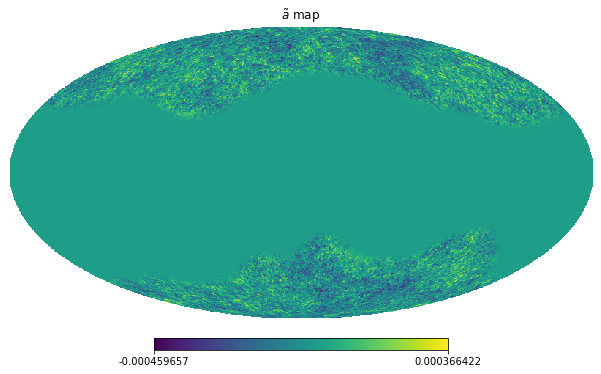

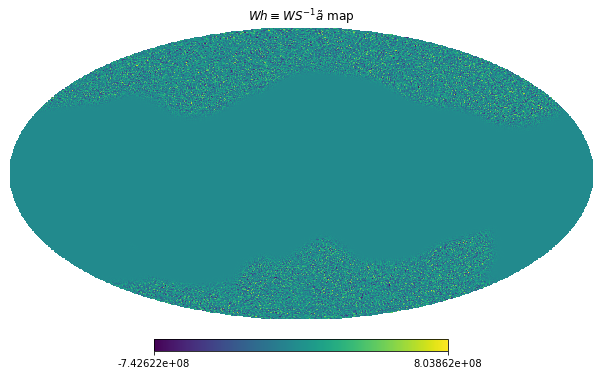

In [215]:
h_data = applySinv(data)
Wh_data = mask*h_data

healpy.mollview(data,title=r'$\tilde{a}$ map')
healpy.mollview(Wh_data,title=r'$Wh\equiv WS^{-1}\tilde{a}$ map')

### Power Spectrum Estimation
The binned power spectrum estimator (including noise) is given by
$$\widehat{C}_b \propto\frac{1}{2}\sum_{\ell,m\geq 0}\Theta_{\ell}(b)[Wh]_{\ell m}[Wh]_{\ell(-m)}(1+\delta^{\rm K}_{m>0})$$
with normalization
$$\mathcal{F}_{bb'} = \frac{1}{2}\langle\int d\hat{n}\,d\hat{n}'[WC_{,b}WA^{-1}\alpha](\hat{n})S^{-1}(\hat{n},\hat{n}')[WC_{,b'}WS^{-1}\alpha](\hat{n}')\rangle_{\alpha}$$
or
$$\mathcal{F}_{bb'} = \frac{1}{2}\langle\int d\hat{n}\,d\hat{n}'Q_b[A^{-1}\alpha](\hat{n})S^{-1}(\hat{n},\hat{n}')Q_b[S^{-1}\alpha](\hat{n}')\rangle_\alpha$$
with
$$Q_b[x](\hat{n}) = [WC_{,b}Wx](\hat{n})$$

In [220]:
# Define ell bins
ell_bins = [(l_arr>=min_l+dl*bin1)&(l_arr<min_l+dl*(bin1+1)) for bin1 in range(Nl)]

#### Compute quadratic estimator
Wh_data_lm = to_lm(Wh_data)
Cl_num = [0.5*np.real(np.sum((1.+1.*(m_arr>0.))*Wh_data_lm*np.conj(Wh_data_lm)*ell_bins[i])) for i in range(Nl)]

In [222]:
### Iterate over realizations
fish = np.zeros((Nl,Nl))
all_alpha = []
for seed in range(N_it):

    ## Compute random realization with known power spectrum
    print("Computing alpha %d of %d"%(seed+1,N_it))
    alpha = generate_alpha(seed)
    all_alpha.append(alpha)

    ## Compute weighted fields
    Sinv_alpha = applySinv(alpha)
    Ainv_alpha = applyAinv(alpha)

    ## Compute Q_b fields
    if seed==0: print("Computing Q_b")
    WSinv_alpha_lm = to_lm(mask*Sinv_alpha)
    WAinv_alpha_lm = to_lm(mask*Ainv_alpha)
    Q_b_Sinv_alpha = [to_map(WSinv_alpha_lm*ell_bins[bin1])*mask for bin1 in range(Nl)]
    Q_b_Ainv_alpha = [to_map(WAinv_alpha_lm*ell_bins[bin1])*mask for bin1 in range(Nl)]

    ## Apply S^-1 weighting
    if seed==0: print("Computing S^-1 Q_b")
    Sinv_Q_b_Sinv_alpha = [applySinv(Q_b_Sinv_alpha[bin1]) for bin1 in range(Nl)]

    ## Compute the Fisher matrix
    if seed==0: print("Computing Fisher matrix")
    for bin1 in range(Nl):
        for bin2 in range(Nl):
            fish[bin1,bin2] += 0.5*np.real(A_pix*np.sum(Q_b_Ainv_alpha[bin1]*(Sinv_Q_b_Sinv_alpha[bin2])))/N_it
        
### Compute full estimator
Cl_est = np.linalg.inv(fish)@Cl_num

Computing alpha 1 of 20
Computing Q_b
Computing S^-1 Q_b
Computing Fisher matrix
Computing alpha 2 of 20
Computing alpha 3 of 20
Computing alpha 4 of 20
Computing alpha 5 of 20
Computing alpha 6 of 20
Computing alpha 7 of 20
Computing alpha 8 of 20
Computing alpha 9 of 20
Computing alpha 10 of 20
Computing alpha 11 of 20
Computing alpha 12 of 20
Computing alpha 13 of 20
Computing alpha 14 of 20
Computing alpha 15 of 20
Computing alpha 16 of 20
Computing alpha 17 of 20
Computing alpha 18 of 20
Computing alpha 19 of 20
Computing alpha 20 of 20


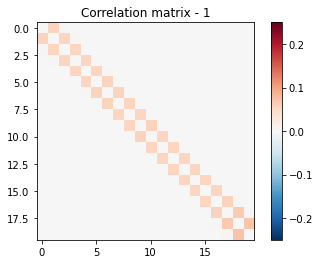

In [223]:
corr_fish = fish/np.sqrt(np.outer(np.diag(fish),np.diag(fish)))
v = 0.25
plt.imshow(corr_fish-np.eye(len(corr_fish)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation matrix - 1")
plt.colorbar();

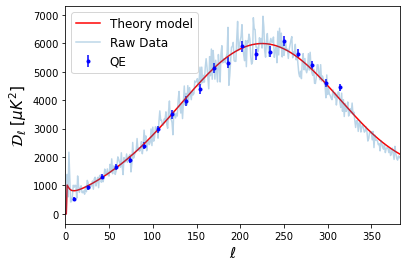

In [224]:
l_av = np.asarray([min_l+dl/2+dl*bin1 for bin1 in range(Nl)])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12

fish_err = np.sqrt(np.diag(np.linalg.inv(fish)))
plt.errorbar(l_av,pref_av*Cl_est,yerr=pref_av*fish_err,marker='.',ls='',label='QE',c='b')
plt.plot(l,pref*Cl_th,label='Theory model',c='r')
plt.plot(l,pref*Cl_raw_data,label='Raw Data',alpha=0.3)
plt.xlim([0,lmax])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
plt.legend(fontsize=12)

### Iterate over multiple data-sets

In [225]:
Cl_ests = []
Cl_ests_raw = []

for ii in range(250):
    if ii%10==0: 
        print("Analyzing simulation %d"%(ii+1))
    # Generate unmasked data
    raw_data = healpy.synfast(Cl_th+Nl_th,Nside)

    # Mask the map
    data = raw_data*mask

    # Filter the data
    h_data = applySinv(data)
    Wh_data = mask*h_data

    # Define ell bins
    ell_bins = [(l_arr>=min_l+dl*bin1)&(l_arr<min_l+dl*(bin1+1)) for bin1 in range(Nl)]

    #### Compute quadratic estimator
    Wh_data_lm = to_lm(Wh_data)
    this_Cl_num = [0.5*np.real(np.sum((1.+1.*(m_arr>0.))*Wh_data_lm*np.conj(Wh_data_lm)*ell_bins[i])) for i in range(Nl)]
    
    Cl_ests.append(np.linalg.inv(fish)@this_Cl_num)
    Cl_ests_raw.append(healpy.anafast(raw_data))

Analyzing simulation 1
Analyzing simulation 11
Analyzing simulation 21
Analyzing simulation 31
Analyzing simulation 41
Analyzing simulation 51
Analyzing simulation 61
Analyzing simulation 71
Analyzing simulation 81
Analyzing simulation 91
Analyzing simulation 101
Analyzing simulation 111
Analyzing simulation 121
Analyzing simulation 131
Analyzing simulation 141
Analyzing simulation 151
Analyzing simulation 161
Analyzing simulation 171
Analyzing simulation 181
Analyzing simulation 191
Analyzing simulation 201
Analyzing simulation 211
Analyzing simulation 221
Analyzing simulation 231
Analyzing simulation 241


Text(0, 0.5, '$\\sigma(\\mathcal{D}_\\ell)\\,\\,[\\mu K^2]$')

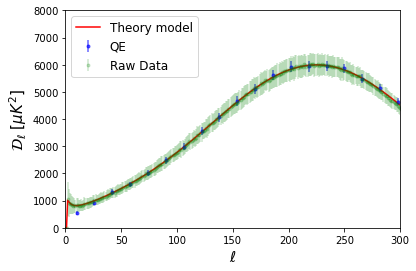

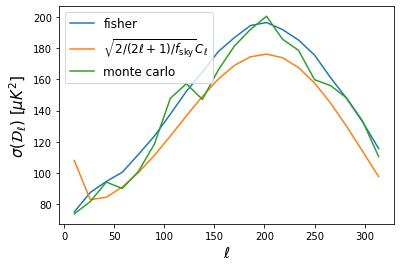

In [226]:
l_av = np.asarray([min_l+dl/2+dl*bin1 for bin1 in range(Nl)])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12

fish_err = np.sqrt(np.diag(np.linalg.inv(fish)))
plt.errorbar(l_av,pref_av*np.asarray(Cl_ests).mean(axis=0),yerr=pref_av*fish_err,marker='.',ls='',label='QE',c='b',alpha=0.6)
plt.plot(l,pref*Cl_th,label='Theory model',c='r')
plt.errorbar(l,pref*np.asarray(Cl_ests_raw).mean(axis=0),yerr=pref*np.asarray(Cl_ests_raw).std(axis=0),
             ls='',marker='.',label='Raw Data',alpha=0.2,c='g')
plt.xlim([0,lmax])
plt.xlabel(r'$\ell$',fontsize=15)
plt.ylabel(r'$\mathcal{D}_\ell\,\,[\mu K^2]$',fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0,8000])
plt.xlim([0,300])

plt.figure()
plt.plot(l_av,pref_av*fish_err,label='fisher')
f_sky = np.mean(mask)
plt.plot(l_av,pref_av*np.sqrt(2./(2*l_av+1.)/dl/f_sky)*Cl_th_interp(l_av),label=r'$\sqrt{2/(2\ell+1)/f_{\rm sky}}C_\ell$')
plt.plot(l_av,pref_av*np.asarray(Cl_ests).std(axis=0),label='monte carlo')
plt.xlabel(r'$\ell$',fontsize=15)
plt.legend(fontsize=12)
plt.ylabel(r'$\sigma(\mathcal{D}_\ell)\,\,[\mu K^2]$',fontsize=15)